### Problem Statement
Financial institutions face significant risks due to loan defaults. Accurately predicting the <br>
probability of default (PD) on loans is critical for risk management and strategic planning. In this <br>
competition, participants are tasked with developing a predictive model that estimates the <br>
probability of default on loans using historical loan data.

To get on with this project, let's import the necessary packages

In [ ]:
# Essential packages for array and dataframe manipulation
import numpy as np
import pandas as pd

# Essential for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Essential for Pipeline components
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Essential for Preprocessing
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Essential for Model selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Essential for Model building
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Essential for getting Metrics/Scores
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import accuracy_score

# Feature selection
from sklearn.feature_selection import RFE

# Essential for Model interpretation
import shap
from scipy.stats import ks_2samp

# Essential for Model dumping
import os, pickle

# Settings/Tools

# To remove warnings from packages
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# For saving plots 
# -- Some plots may require a lot of computing power for every run, having the plot as an image comes in handy for quick reference
# - Image properties such as the path, the image name and the image file extension are defined by the function
def save_fig(fig_id, tight_layout=True, fig_extension="png"):
    path = os.path.join("images/", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension)

In [147]:
# Loading the data
# -- also removing the additional index column created when loading
data = pd.read_csv("data/data_science_competition_2024.csv", index_col=0)

In [4]:
# To get a glimpse of the data

data.sample()

,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
75721,149b1f4a-2a8f-4ba4-a9bc-9dbd3da16279,male,2023 11 26,USD,Zimbabwe,male,True,Software Developer,Harare,24000.0,2,26104.306663,0.21,44,2,44,2308.09046,married,44,Did not default


In [5]:
# To get the array shape, it's important to know how big the data is..

data.shape

(100000, 20)

In [6]:
# Describing the column names can give an idea of what each column represents and what is expected of it

column_description = np.array([
    "Random generated id for loan",
    "The gender of the borrower",
    "The date the borrower received funds",
    "The currency in which the loan was given",
    "The country the loan was given in",
    "The sex of the loan borrower",
    "The employment status of borrower",
    "The borrower's job",
    "the location where the loan was taken",
    "The amount of money the borrower received",
    "Number of other missed payments",
    "The amount the borrower owes",
    "The interest rate of the loan the borrower was given",
    "The age of the borrower",
    "Number of ohter missed payments",
    "The number of months still outstanding on a loan",
    "The borrower's salary",
    "The marital status of the borrower",
    "The age of the borrower",
    "Whether the borrower defaulted or not a loan"
    ])



variable_desc = pd.DataFrame(column_description, index=data.columns, columns=["Variable Description"])
variable_desc

,Variable Description
loan_id,Random generated id for loan
gender,The gender of the borrower
disbursemet_date,The date the borrower received funds
currency,The currency in which the loan was given
country,The country the loan was given in
sex,The sex of the loan borrower
is_employed,The employment status of borrower
job,The borrower's job
location,the location where the loan was taken
loan_amount,The amount of money the borrower received


In [148]:
# Removing unnecessary features
# -- e.g the columns sex, age.1 and number_of_defaults.1 already exist in the data, therefore, they are useless
# -- loan id has no significant information to give us

cols_to_del = ["loan_id", "sex", "age.1", "number_of_defaults.1"]
data.drop(cols_to_del, axis=1, inplace=True)

# Renaming the remaining_term to maintain a consistent naming convention, also to avoid problems in parsing the column name
data.rename(columns={"remaining term": "remaining_term"}, inplace=True)

# Splitting the data into data and labels
# -- "Loan Default" is a string, an integer can help in making the label less ambiguous to models
# -- therefore y is mapped on to "feature_names" with "Defaulted" as 1 and "Did not default" as 0

feature_names = np.array(["Did not default", "Defaulted"])
X = data.drop("Loan Status", axis=1).copy()
y = np.array(data["Loan Status"]=="Defaulted", dtype=int)

In [8]:
# X.to_csv("x.csv", index=None)

In [9]:
# pd.DataFrame(y).to_csv("y.csv", index=None)

In [10]:
# Checking to see if the data shape is consistent in X and y

X.shape, y.shape

((100000, 15), (100000,))

In [11]:
# Creating a copy of the data to toy around with

df = X.copy()

In [12]:
# Checking category columns represented by data type "object"

df.select_dtypes("object").sample(2)

,gender,disbursemet_date,currency,country,job,location,remaining_term,marital_status
84348,other,2023 05 26,USD,Zimbabwe,Engineer,Gweru,70_,married
1457,other,2020 12 11,USD,Zimbabwe,Accountant,Bulawayo,48,divorced


gender
male      35028
female    32685
other     32287
Name: count, dtype: int64


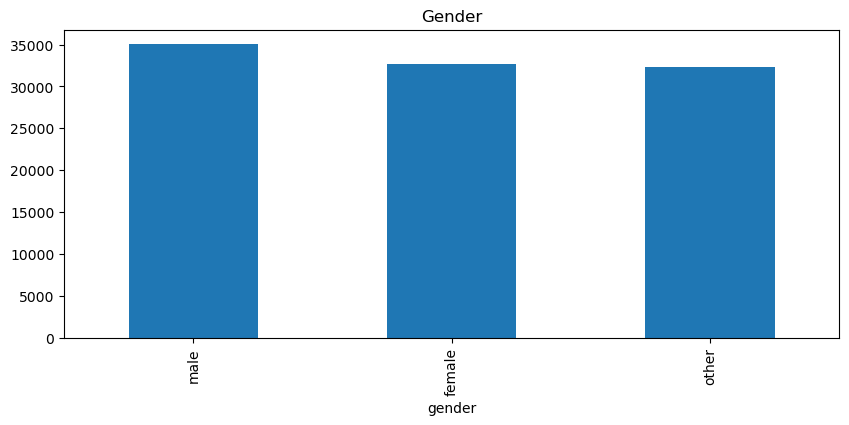

In [13]:
# Evaluating the count of each category in the gender column
# -- plotting the count by means of a bar graph


plt.figure(figsize=(10, 4))
gender_count = df["gender"].value_counts()
gender_count.plot(kind="bar", title="Gender")
print(gender_count)

In [14]:
# From the plot, there seems to be a slight difference between the number of males and females in the data.
# The number of males is a bit higher

In [15]:
# Other is an ambiguous category, by Zimbabwean convention: there is only male and female
# -- replace "other" by nan, these nan values will be imputed later on

df["gender"].replace("other", np.NaN, inplace=True)

In [16]:
# Taking a look at the structure of the values of the disbursemet_date column

df.sample(5)["disbursemet_date"]

95120    2020 04 20
51027    2023 05 25
34695    2021 11 29
56858    2020 08 24
4699     2023 10 01
Name: disbursemet_date, dtype: object

In [17]:
# Convert the "disbursemet_date" column to dateime datatype
df["disbursemet_date"] = pd.to_datetime(df["disbursemet_date"])

# Making features out of the datetime colums
# - features include: year, month, day and weekday(Sunday, Monday... but as int), all derived from the date.
df["year_of_disbursement"] = df['disbursemet_date'].dt.year
df["month_of_disbursement"] = df['disbursemet_date'].dt.month
df["day_of_disbursement"] = df['disbursemet_date'].dt.day
df["weekday_of_disbursement"] = df['disbursemet_date'].dt.dayofweek

# Since the "disbursemet_date" column is no longer essential, let's drop it
df.drop("disbursemet_date", axis=1, inplace=True)

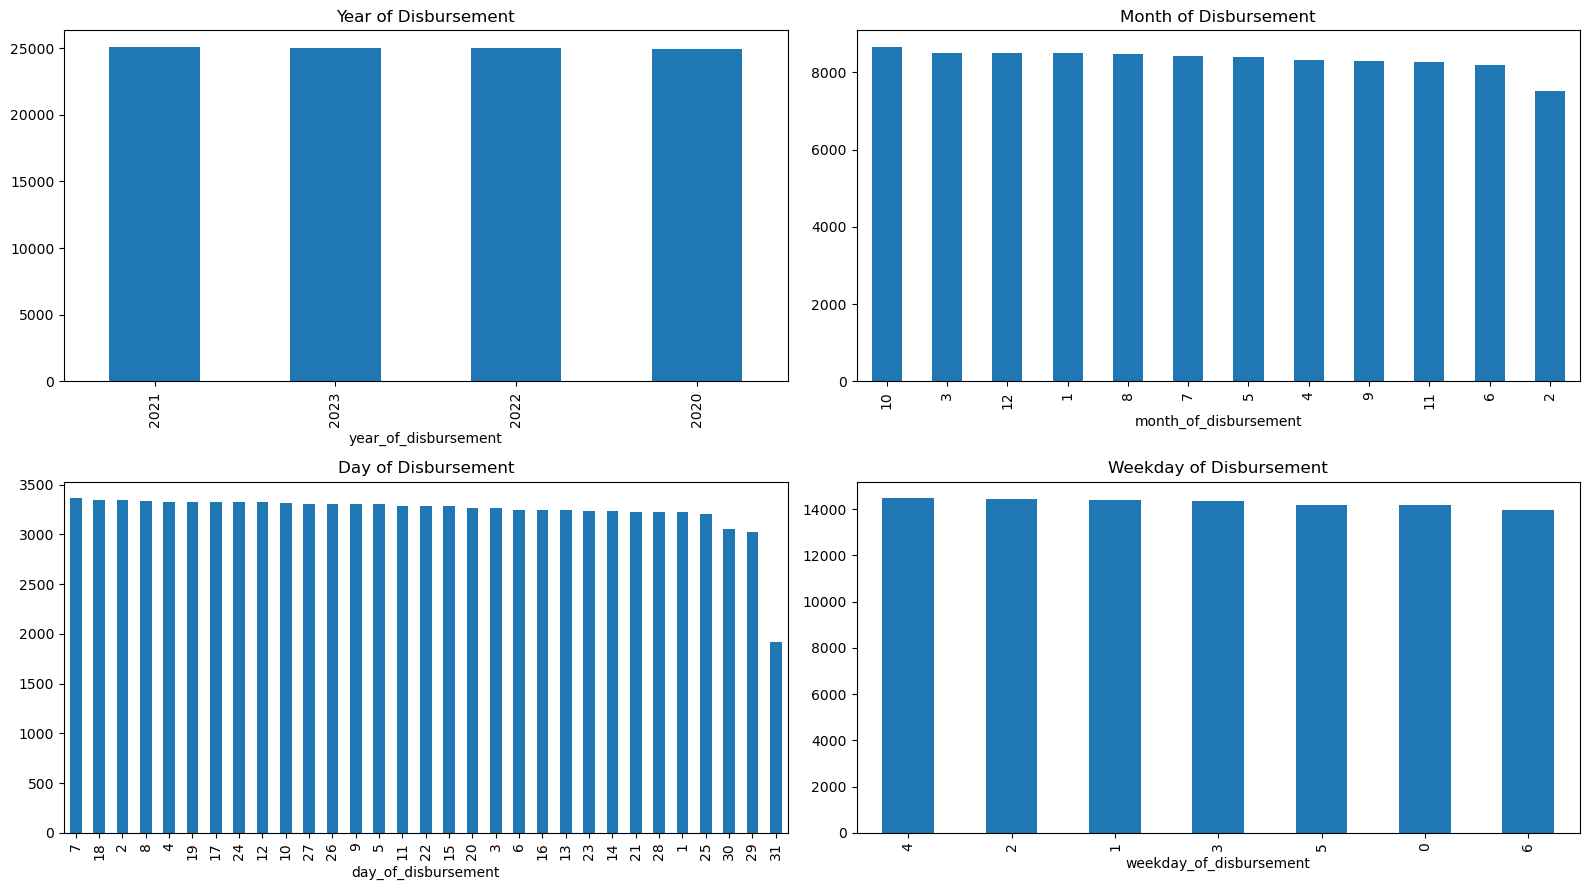

In [18]:
# Let's take a look at how our new found variables are distributed by plotting bar graphs of counts
# -- using a neat trick of subplots to have the close together as one major plot with four parts

fig, axes = plt.subplots(2, 2, figsize=(16, 9))
df['year_of_disbursement'].value_counts().plot(kind="bar", ax=axes[0, 0], title="Year of Disbursement")
df['month_of_disbursement'].value_counts().plot(kind="bar", ax=axes[0, 1], title="Month of Disbursement")
df['day_of_disbursement'].value_counts().plot(kind="bar", ax=axes[1, 0], title="Day of Disbursement")
df['weekday_of_disbursement'].value_counts().plot(kind="bar", ax=axes[1, 1], title="Weekday of Disbursement")
plt.tight_layout()
plt.show()

In [19]:
# From the plot:

# -- the data is from loans taken from 2020 to 2023

# Observation - February has least amount of loans taken
# Assumption - February has the least amount of days so it's bound to have the least amount of loan taken

# Observation: 31 has the least amount of loans taken
# Assumption: 31 is the least day in months e.g February, April... don't have 31

# -- weekdays seem to be slightly well balanced

In [20]:
# Taking a look at the "currency" column

df["currency"].value_counts()

currency
USD     99980
$USD       20
Name: count, dtype: int64

In [21]:
# Observation - It seems the column has only one value (the other is just a extended variant meaning the same thing as the other)
# Action - Drop the whole column

In [22]:
df.drop("currency", axis=1, inplace=True)

In [23]:
# Taking a look at the "country" column

In [24]:
df["country"].value_counts()

country
Zimbabwe    99787
zimbabwe      100
Zim            13
Name: count, dtype: int64

In [25]:
# Observation - It seems the column has only one value (the others are just extended variants meaning the same thing)
# Action - Drop the whole column

In [26]:
df.drop("country", axis=1, inplace=True)

In [27]:
# Taking a look at the "is_employed" values and their counts

df["is_employed"].value_counts()

is_employed
True     95864
False     4136
Name: count, dtype: int64

In [28]:
# It seems there are 4136 marked down as False, out of curiosity let's look at how that sums up with the "job" column

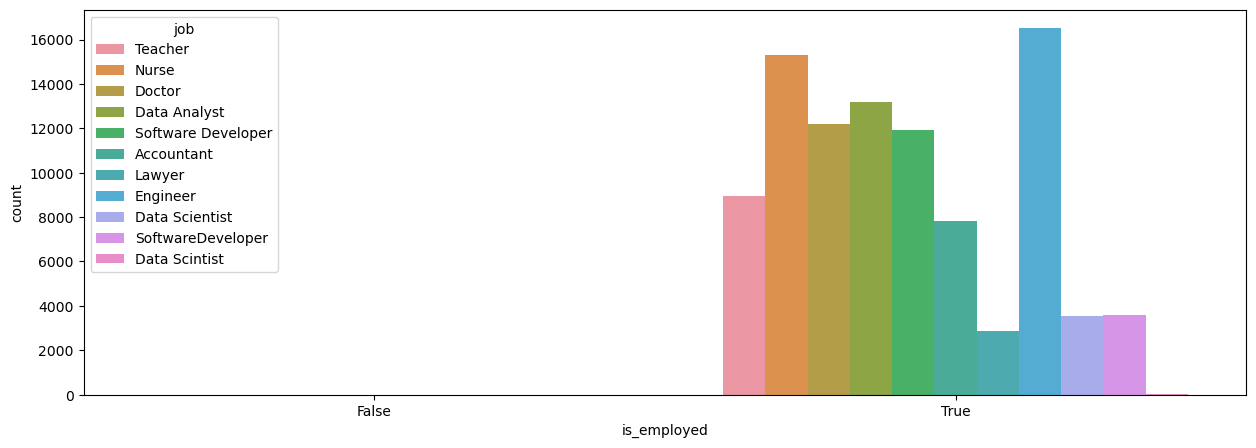

In [29]:
plt.figure(figsize=(15, 5))
sns.countplot(x='is_employed', data=df, hue='job')
plt.show()

In [30]:
# Observation - There are no jobs at the "False" side of things, in the "job" column, the values are nan

In [31]:
# Verifying if the nan values in "job" column are the same values labeled "False" in "is_employed"

np.allclose(df[df["is_employed"]==False].index, df[df["job"].isnull()].index)

True

In [32]:
# Giving the nan values their own category in "job" called "Unemployed"
# And since that's that, the "is_employed" column is no longer of use to us

df["job"].fillna("Unemployed", inplace=True)
df.drop("is_employed", axis=1, inplace=True)

In [33]:
# Taking a look at the value counts of the "job" columns

df["job"].value_counts()

job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
Unemployed             4136
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64

In [34]:
# Observation - Some values are misspelled
# Action - Rename the misspelled values

In [35]:
# Pandas has a sweet feature which allows replacing old values with new ones

df["job"].replace({"SoftwareDeveloper": "Software Developer", "Data Scintist": "Data Scientist"}, inplace=True)

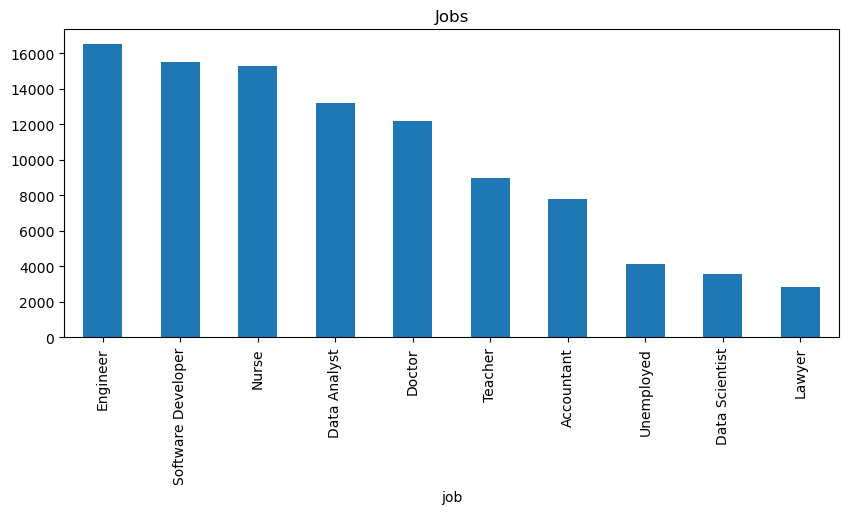

In [36]:
# Plotting the job value counts

plt.figure(figsize=(10, 4))
df["job"].value_counts().plot(kind="bar", title="Jobs")
plt.show()

In [37]:
# From the plot:

# The number of recorded unemployed people who took a loan is higher than both "Data Scientists" and "Lawyers"  

In [38]:
# Taking a look a location column

df["location"].value_counts()

location
Harare               8338
Bulawayo             8078
Mutare               8062
Gweru                7803
Masvingo             7476
                     ... 
 Redcliff               1
Victoria Falls          1
Victoria Falls          1
   Gokwe                1
Gokwe                   1
Name: count, Length: 157, dtype: int64

In [39]:
# Observatin - values have unncessary whitespaces
# Action - strip out the whitespaces

In [40]:
# Using the .apply to make changes to the column values

df["location"] = df["location"].apply(lambda x: str(x).strip())

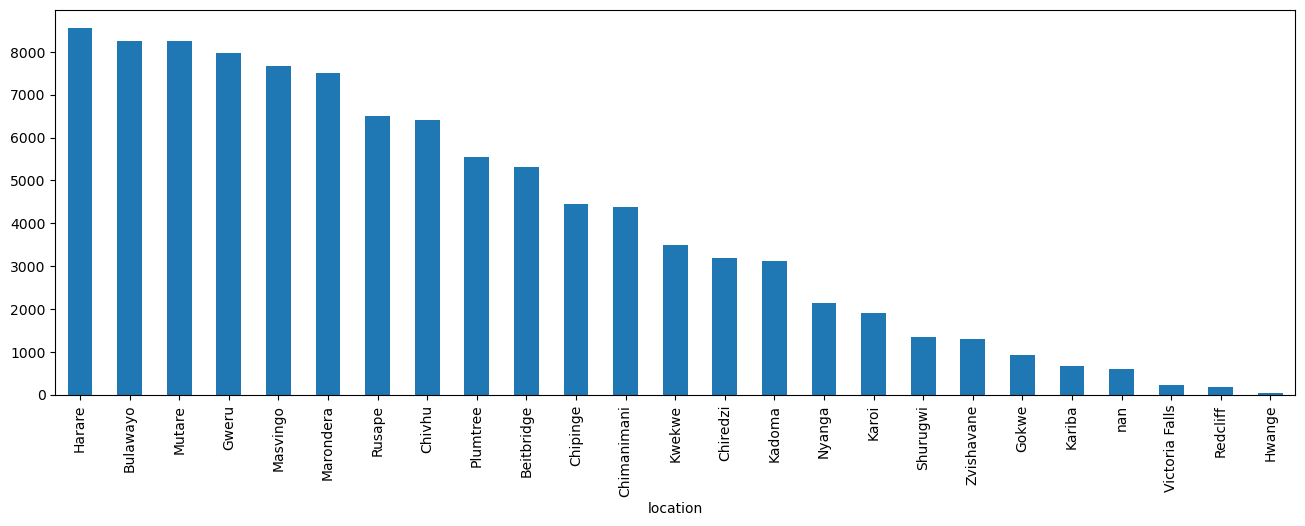

In [ ]:
# Plotting the values

plt.figure(figsize=(16, 5))
df["location"].value_counts().plot(kind="bar")
plt.show()

In [42]:
df["location"].value_counts()

location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
nan                595
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64

In [ ]:
# Observation: Some categories have very few values
# Action: Take all very underepresented categories and combine them into one categories

# Observation: Most loans are taken in Harare

In [44]:
# Take categories with less than 1000 values and combine them into a new category called Others

a = df["location"].value_counts()
df["location"].replace(list(a[a<1000].index), "Others", inplace=True)

In [45]:
# Taking a look at "remaing_term" column

df["remaining_term"].value_counts()

remaining_term
51       3329
49       3321
53       3314
54       3276
50       3220
         ... 
108         1
15          1
93          1
20          1
90_         1
Name: count, Length: 262, dtype: int64

In [ ]:
# Observation: The data is supposedly supposed to be number (of month). Some dodgy naming of values with underscore after a number
# Action: Remove the underscore and change the data type to integer

In [46]:
# Using .apply to remove the underscore in values and changing data type to int

df["remaining_term"] = df["remaining_term"].apply(lambda x: int("".join([value[:-1] if "_" in value else value for value in x])))

In [47]:
# Taking a look at the marital status column

marital_stat_count = df["marital_status"].value_counts()
marital_stat_count

marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64

In [48]:
marital_stat_count.index

Index(['married', 'divorced', 'single', ' '], dtype='object', name='marital_status')

In [ ]:
# Observation: Seeing some dodgy looking value of just a space
# Action: Replace that value with nan, to be imputed of course

In [49]:
# Replacing " " with nan

df["marital_status"].replace(" ", np.NaN, inplace=True)

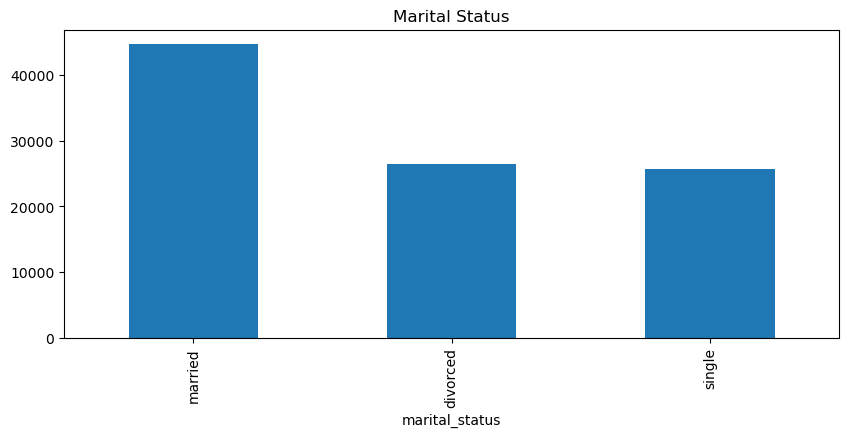

In [50]:
# Plotting the values of each category

plt.figure(figsize=(10, 4))
df["marital_status"].value_counts().plot(kind="bar", title="Marital Status")
plt.show()

In [ ]:
# Observation: There are more records of married individuals than those of single or divorced

In [ ]:
# Checking to see if there any data duplicates

df.duplicated().sum()

In [51]:
# Just peaking the numerical values

df.select_dtypes("number").sample(2)

,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining_term,salary,year_of_disbursement,month_of_disbursement,day_of_disbursement,weekday_of_disbursement
43340,17000.0,0,31678.944198,0.22,42,52,2446.730067,2022,11,11,4
14011,17000.0,1,33184.590999,0.20,38,76,3052.329404,2021,3,8,0


In [52]:
# Taking a statistical view the numerical values

df.describe()

0

In [ ]:
for column in df.select_dtypes("number").columns:
    plt.figure(figsize=(10, 3))
    sns.distplot(df[column], label=column.title())
    plt.show()

In [ ]:
# Observation: There are so many outlier values for some variables
# Action: Cap the outliers

In [53]:
# Creating a cut-off point using mean and standard deviation
# If data goes beyond the mean + standard_deviation*3, it is then consider to have crossed the cutoff point
# Any outlier encountered are replace by the cap value

for i in ["loan_amount", "outstanding_balance", "salary", "remaining_term"]:
    data_mean, data_std = np.mean(df[i]), np.std(df[i])

    # define outliers
    cut_off = data_std * 3
    upper = data_mean + cut_off

    # identify outliers
    outliers = [x for x in df[i] if x > upper]
    df[i].replace(outliers, upper, inplace=True)

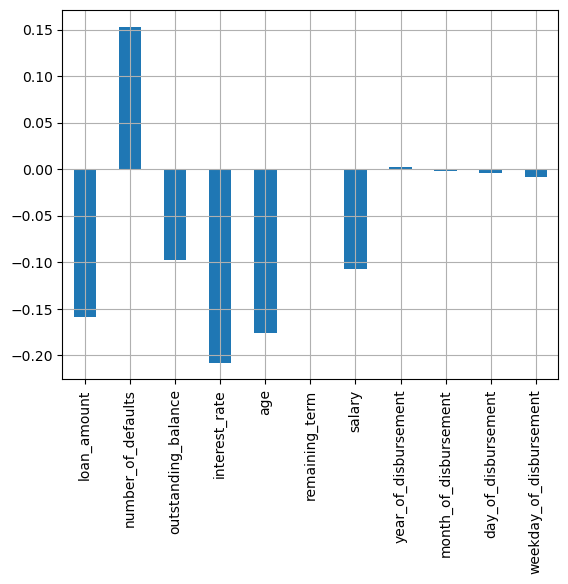

In [57]:
# Checking the correlation of values with those of y

df.select_dtypes("number").corrwith(pd.Series(y)).plot(kind="bar")
plt.grid(True)
plt.show()

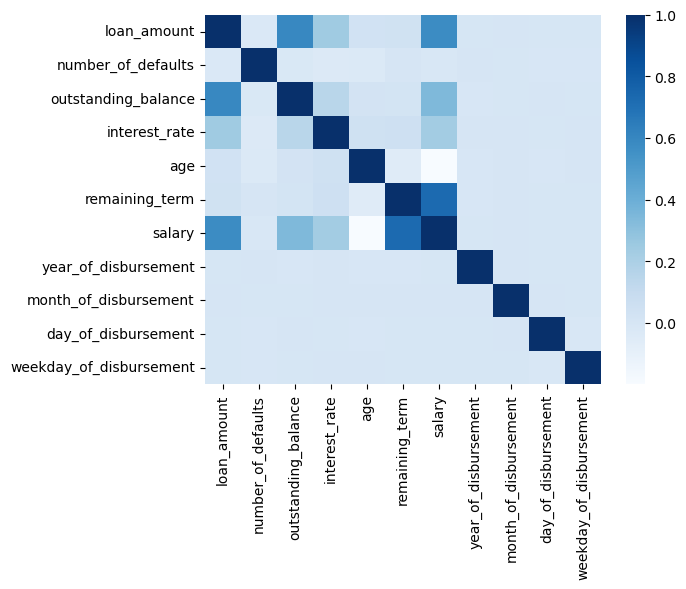

In [58]:
# Plotting a correlation matrix

sns.heatmap(df.select_dtypes("number").corr(), cmap="Blues")
plt.show()

In [59]:
# Reviewing the correlation values of salary

df.select_dtypes("number").corr()["salary"].sort_values(ascending=False)

salary                     1.000000
remaining_term             0.729272
loan_amount                0.576988
outstanding_balance        0.342495
interest_rate              0.234471
month_of_disbursement      0.003867
weekday_of_disbursement    0.001775
day_of_disbursement       -0.000418
year_of_disbursement      -0.000794
number_of_defaults        -0.010649
age                       -0.198870
Name: salary, dtype: float64

In [ ]:
# Observation: Salary has an unusual relationship with remaining_term
# Assumption: People with higher salary tend to take loans that take a longer time to pay off

In [60]:
df.select_dtypes("number").corr()["loan_amount"].sort_values(ascending=False)

loan_amount                1.000000
outstanding_balance        0.594911
salary                     0.576988
interest_rate              0.242740
remaining_term             0.036197
age                        0.034724
month_of_disbursement      0.004976
weekday_of_disbursement    0.002230
day_of_disbursement        0.000495
year_of_disbursement      -0.000153
number_of_defaults        -0.024286
Name: loan_amount, dtype: float64

In [ ]:
# Observation: Loan amount has high correlation with salary and outstanding_balance
# Assumption: People with higher salaries take big loans which result in high outstanding_balance

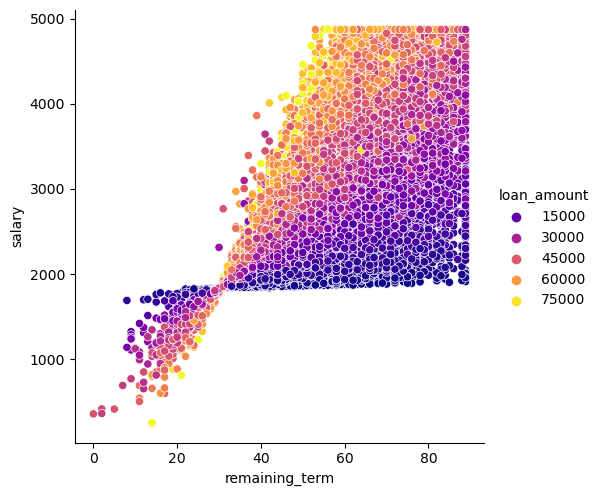

In [61]:
# Plotting the relationship between salary and remaining_term with loan_amount as a contributing factor

sns.pairplot(data=df, x_vars="remaining_term", y_vars="salary", size=5, hue="loan_amount", palette="plasma")
plt.show()

In [ ]:
# Observation: The shape is indeed close to linear

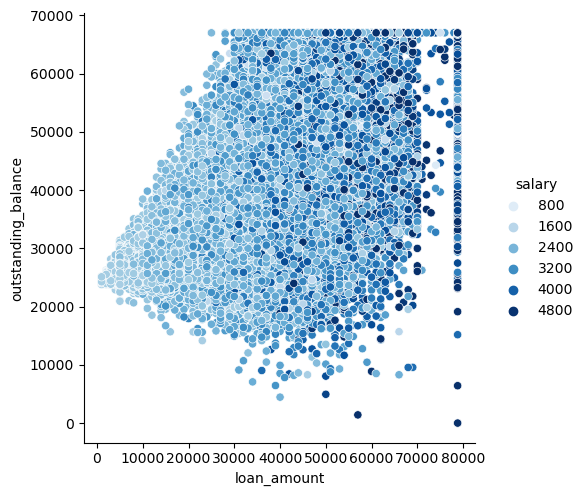

In [62]:
# Plotting relationship between loan_amount and outstanding_balance

sns.pairplot(data=df, x_vars="loan_amount", y_vars="outstanding_balance", size=5, hue="salary", palette="Blues")
plt.show()

In [ ]:
# Observation: The shape is slightly linear and darker spots appearing at the right corner 
# Assumption: the association between high salary and high loan_amount is noticeable

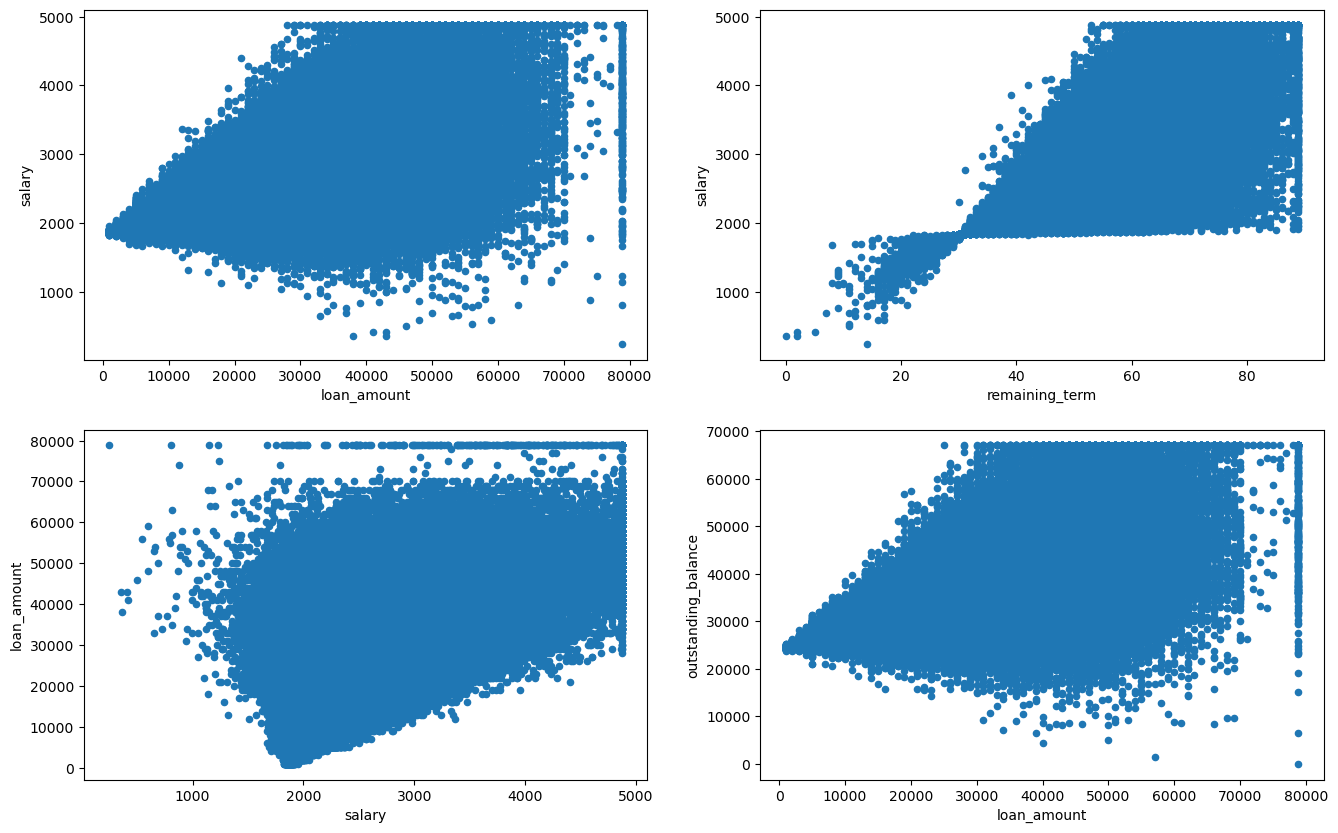

In [63]:
# Plotting each plot with interesting relationships

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
df.plot(kind="scatter", x="loan_amount", y="salary", ax=axes[0, 0])
df.plot(kind="scatter", x="remaining_term", y="salary", ax=axes[0, 1])
df.plot(kind="scatter", x="salary", y="loan_amount", ax=axes[1, 0])
df.plot(kind="scatter", x="loan_amount", y="outstanding_balance", ax=axes[1, 1])
plt.show()

In [64]:
# # This plot actually takes some time to load

# temp_df = df.select_dtypes("number")
# temp_df["y"] = y
# plt.figure(figsize=(16, 9))
# sns.pairplot(temp_df, hue="y")
# save_fig("overall_pairplot")
# plt.show()

In [ ]:
# To summon the plot:

<img src="images/overall_pairplot.png">

In [ ]:
# From the plot:
# The plot had all relationships of variables and how they linked with the target
# There are actually some plots that show some signicant distinction between portions of the target

# Action: Note down those with the strongest connection to the target and combine into a new feature

In [65]:
# Let's quickly make some column names for the features being tested
cols_for_new = [f"feature{i}" for i in range(1, 16)]

In [66]:
# A script that identifies a list with all the features and maps them to the feature name

temp_df = df.copy()

features = [
    temp_df["number_of_defaults"] * temp_df["interest_rate"],
    temp_df["loan_amount"] * temp_df["interest_rate"],
    temp_df["outstanding_balance"] * temp_df["interest_rate"],
    temp_df["outstanding_balance"] * temp_df["age"],
    temp_df["interest_rate"] * temp_df["weekday_of_disbursement"],
    temp_df["interest_rate"] * temp_df["day_of_disbursement"],
    temp_df["interest_rate"] * temp_df["month_of_disbursement"],
    temp_df["interest_rate"] * temp_df["year_of_disbursement"],
    temp_df["interest_rate"] * temp_df["salary"],
    temp_df["interest_rate"] * temp_df["remaining_term"],
    temp_df["interest_rate"] * temp_df["age"],
    temp_df["age"] * temp_df["day_of_disbursement"],
    temp_df["age"] * temp_df["month_of_disbursement"],
    temp_df["age"] * temp_df["year_of_disbursement"],
    temp_df["age"] * temp_df["remaining_term"]]

for i in range(len(cols_for_new)):
    temp_df[cols_for_new[i]] = features[i]

In [67]:
# Assessing strength of features (new features included) with y

temp_df.select_dtypes("number").corrwith(pd.Series(y)).sort_values(ascending=False)

number_of_defaults         0.153259
feature1                   0.136355
year_of_disbursement       0.002693
remaining_term            -0.000076
month_of_disbursement     -0.002315
day_of_disbursement       -0.003647
weekday_of_disbursement   -0.008218
feature5                  -0.035308
feature6                  -0.036351
feature7                  -0.036478
feature13                 -0.037993
feature12                 -0.038176
feature15                 -0.072099
feature10                 -0.073534
outstanding_balance       -0.097393
salary                    -0.106724
feature3                  -0.138862
feature4                  -0.140293
feature9                  -0.145641
loan_amount               -0.158489
feature2                  -0.165898
feature14                 -0.176029
age                       -0.176039
feature8                  -0.207742
interest_rate             -0.207767
feature11                 -0.246522
dtype: float64

In [68]:
# Take down features which seem to be powerful and reasonable
# Reasonable?? Month and year simply mimic poorly the trend of the mother feature, which is more of a burden than a blessing

df["loan_amount_by_interest_rate"] = df["loan_amount"] * df["interest_rate"]
df["interest_rate_by_age"] = df["interest_rate"] * df["age"]
df["interest_rate_by_salary"] = df["interest_rate"] * df["salary"]
df["outstanding_balance_by_age"] = df["outstanding_balance"] * df["age"]

In [70]:
# Experimenting with new features and comparing their relevance with correlation to y

print(pd.DataFrame(y).corrwith(df["outstanding_balance"] / df["salary"]).sort_values(ascending=False))
print(pd.DataFrame(y).corrwith(df["loan_amount"] * (df["outstanding_balance"] / df["salary"])).sort_values(ascending=False))
print(pd.DataFrame(y).corrwith(df["loan_amount"] * df["interest_rate"] * (df["remaining_term"] / 12)).sort_values(ascending=False))
print(pd.DataFrame(y).corrwith((df["loan_amount"] * df["interest_rate"] * (df["remaining_term"] / 12)) / df["salary"]).sort_values(ascending=False))

0   -0.01385
dtype: float64

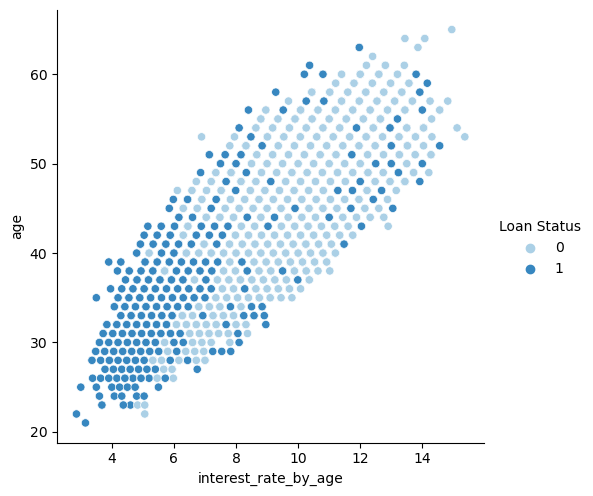

In [77]:
# Visualizing the relation between the new feature "interest_rate_by_age" and "age"

temp_df = pd.concat([df, pd.DataFrame(y, columns=["Loan Status"])], axis=1)
sns.pairplot(data=temp_df, x_vars="interest_rate_by_age", y_vars="age", size=5, hue="Loan Status", palette="Blues")
plt.show()

In [ ]:
# Observation: There is some visible distinction between the two portions of the data
# Problem: The data is severely skewed so much that many data points can be misclassified

In [84]:
# Let's see if we have missing values from the category columns

df.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   gender          67713 non-null   object
 1   job             100000 non-null  object
 2   location        100000 non-null  object
 3   marital_status  96873 non-null   object
dtypes: object(4)
memory usage: 3.8+ MB


In [149]:
# Component for cleaning the data

class StarterCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X_):
        return self
    def transform(self, X_):
        # To avoid writing over original data
        X = X_.copy()

        # Changing questionable values to NaN
        X["gender"].replace("other", np.NaN, inplace=True)
        X["marital_status"].replace(" ", np.NaN, inplace=True)

        # Splitting the date to years, months and days
        X["disbursemet_date"] = X["disbursemet_date"].astype("datetime64[ns]")
        X["year_of_disbursement"] = X['disbursemet_date'].dt.year
        X["month_of_disbursement"] = X['disbursemet_date'].dt.month
        X["day_of_disbursement"] = X['disbursemet_date'].dt.day
        X["weekday_of_disbursement"] = X['disbursemet_date'].dt.dayofweek

        # Removing not-so-helpful variables
        cols_to_del2 = ["disbursemet_date", "currency", "country"]
        X.drop(cols_to_del2, axis=1, inplace=True)

        # Renaming misspelled data instances
        X["job"].replace({"Software Developer": "SoftwareDeveloper", "Data Scintist": "DataScientist",
                          "Data Scientist": "DataScientist", "Data Analyst": "DataAnalyst"}, inplace=True)
        X["job"].fillna("Unemployed", inplace=True)
        X.drop("is_employed", axis=1, inplace=True)

        # Correcting faulty values
        X["location"] = X["location"].apply(lambda x: str(x).strip())
        a = X["location"].value_counts()
        X["location"].replace(list(a[a<1000].index), "Others", inplace=True)
        X["remaining_term"] = X["remaining_term"].apply(lambda x: int("".join([value[:-1] if "_" in value else value for value in x])))


        # Handle outliers
        for i in ["loan_amount", "outstanding_balance", "salary", "remaining_term"]:
            data_mean, data_std = np.mean(X[i]), np.std(X[i])
        
            cut_off = data_std * 3
            upper = data_mean + cut_off
            
            outliers = [x for x in X[i] if x > upper]
            X[i].replace(outliers, upper, inplace=True)
        
        return X

In [150]:
# Component for adding new features

class CreateFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X_):
        return self
    def transform(self, X_):
        X = X_.copy()

        # Targeting new columns to fresh names with their new values

        X["interest_amount"] = X["loan_amount"] * X["interest_rate"] * (X["remaining_term"] / 12)
        X['interest_per_salary'] = X["interest_amount"] / X["salary"]
        X["loan_amount_by_interest_rate"] = X["loan_amount"] * X["interest_rate"]
        X["interest_rate_by_age"] = X["interest_rate"] * X["age"]
        X["interest_rate_by_salary"] = X["interest_rate"] * X["salary"]
        X["outstanding_balance_by_age"] = X["outstanding_balance"] * X["age"]

        return X

In [152]:
# Applying the cleaner and feature adding pipeline to transform the original X set

X_cleaned = StarterCleaner().fit_transform(X)
X_featured = CreateFeatures().fit_transform(X_cleaned)

In [153]:
cols_impute = ["marital_status"]
X_featured[cols_impute] = SimpleImputer(strategy="most_frequent").fit_transform(X_featured[cols_impute])

one_hot_location = OneHotEncoder(sparse=False)
location_encoded = one_hot_location.fit_transform(X_featured[["location"]])
location_columns = [f"location_{i}" for i in list(one_hot_location.categories_[0])]
X_featured[location_columns] = location_encoded

In [154]:
# Impute gender using a special model
# Dataset for imputing
# M_train - Values with know gender
# n_train - the known gender for M_train
# M_test - values with unknown gender

M_train = X_featured.loc[(X_featured[X_featured["gender"].notnull()]).index].select_dtypes("number")
M_test = X_featured.loc[(X_featured[X_featured["gender"].isnull()]).index].select_dtypes("number")
n_train = X_featured.loc[(X_featured[X_featured["gender"].notnull()]).index]["gender"]

In [155]:
# Using Random Forest as the imputer model

rnd_imputer = RandomForestClassifier(max_depth=23, max_features=22, n_estimators=289, n_jobs=-1, random_state=42)
rnd_imputer.fit(M_train, n_train)

RandomForestClassifier(max_depth=23, max_features=22, n_estimators=289,
                       n_jobs=-1, random_state=42)

In [156]:
# Replacing the missing values with the predicted values

X_featured["gender"][X_featured["gender"].isnull()] = rnd_imputer.predict(M_test)

In [157]:
# Selecting columns for specific transformations
# Numerical values for scaling and categorical categories for encoding
# Whilst number_of_defaults and interest_rate can be categorical, they are on the ordinal side

cols_to_encode = ["gender", "job", "marital_status"]
cols_to_scale = ["loan_amount", "outstanding_balance", "number_of_defaults", "interest_rate", "age",
                 "remaining_term", "salary", "year_of_disbursement", "month_of_disbursement",
                 "day_of_disbursement", "interest_amount", "interest_per_salary",
                 "loan_amount_by_interest_rate", "interest_rate_by_age", "interest_rate_by_salary", "outstanding_balance_by_age"]

# Column Transformer gathers all transformations and operations and produces a collective result from the operation

preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(sparse=False), cols_to_encode),
    ("scale", RobustScaler(), cols_to_scale)
])

# The output is an np.array
X_processed_arr = preprocessor.fit_transform(X_featured)

In [158]:
# To map on appropriate column names to the appropriate values
# Going through the transformer "onehot" and gathering the categories and making up column names

encoder = preprocessor.named_transformers_["onehot"]
one_hot_cols = list()
for i in range(len(cols_to_encode)):
    one_hot_cols += [f"{cols_to_encode[i]}_{j}" for j in list(encoder.categories_[i])]

In [159]:
# Making dataframe with appropriate columns

X_processed = pd.DataFrame(X_processed_arr, columns=one_hot_cols+cols_to_scale)

In [160]:
# Adding the location column which was encoded when we imputed gender

X_processed[location_columns] = location_encoded

In [161]:
# Splitting data into training set and validation set
# Using stratify to even out the distribution of the y variable

X_train, X_valid, y_train, y_valid = train_test_split(X_processed, y, random_state=42, test_size=0.20, stratify=y)

In [162]:
# Using cross validation to test out the performance, measuring score using roc_auc

def evaluate_model(model, X, y, scoring="roc_auc"):
    cv = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, verbose=2)
    return scores

In [163]:
# Testing out models for performance

models = [
    ('LogisticRegression', LogisticRegression(solver="liblinear", random_state=42, n_jobs=-1)),
    ('Linear Discriminant', LinearDiscriminantAnalysis(solver="svd")),
    ("Naive Bayes", GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, min_samples_leaf=8)),
    ("Linear SVC", LinearSVC(class_weight="balanced", C=0.001)),
    ("KNearest Neighbor", KNeighborsClassifier(n_neighbors=30)),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=10, random_state=42)),
]
   

result = []

for model_name, model in models:
    score = evaluate_model(model, X_train, y_train, "roc_auc")
    result.append(score)
    print(f"Finished - {model}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished


Finished - LogisticRegression(n_jobs=-1, random_state=42, solver='liblinear')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


Finished - LinearDiscriminantAnalysis()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Finished - GaussianNB()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished


Finished - DecisionTreeClassifier(min_samples_leaf=8, random_state=42)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Finished - LinearSVC(C=0.001, class_weight='balanced')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished


Finished - KNeighborsClassifier(n_neighbors=30)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


Finished - RandomForestClassifier(n_estimators=10, random_state=42)


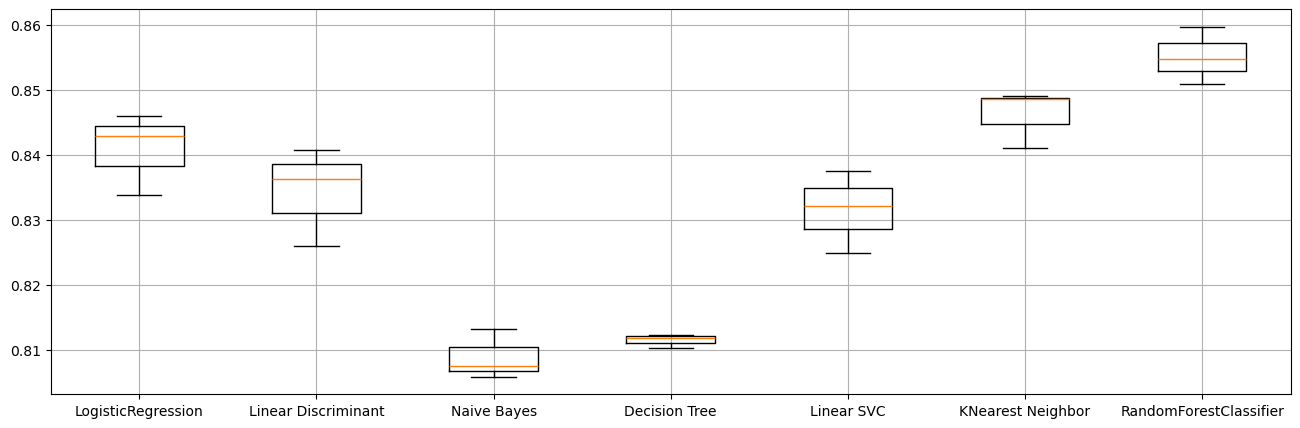

In [164]:
# Plotting the results for better perspective

plt.figure(figsize=(16, 5))
plt.boxplot(result, labels=[model_name for model_name, model in models])
plt.grid(True)
plt.show()

In [165]:
# Displaying the list of score in a Series with the highest scoring model on top

index = [model_name for model_name, model in models]
pd.Series([i.mean() for i in result], index=index).sort_values(ascending=False)

RandomForestClassifier    0.855115
KNearest Neighbor         0.846224
LogisticRegression        0.840913
Linear Discriminant       0.834343
Linear SVC                0.831536
Decision Tree             0.811483
Naive Bayes               0.808910
dtype: float64

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.0s finished


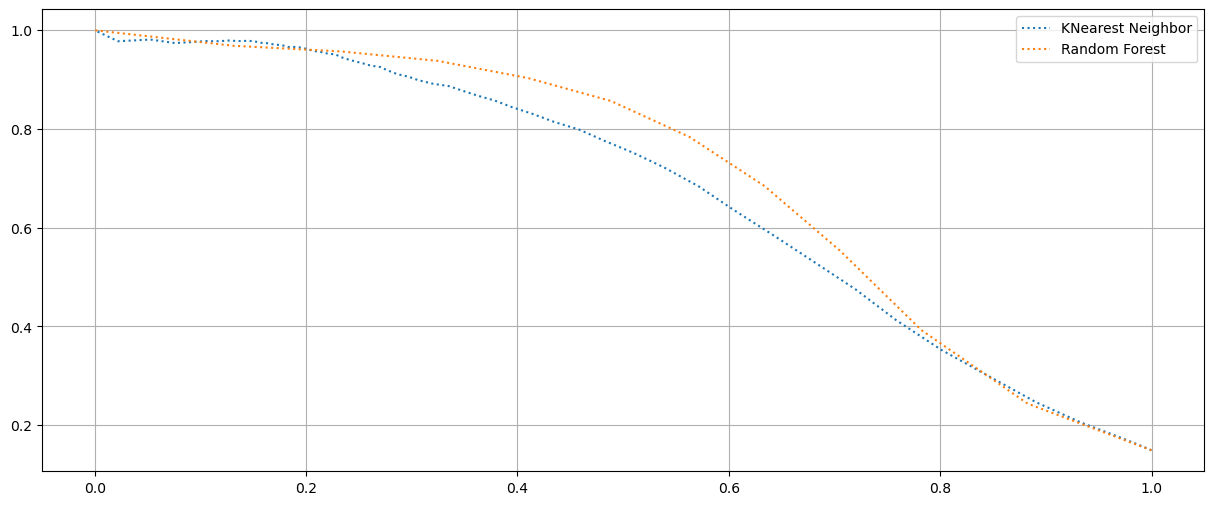

In [166]:
# Plotting the precision_recall curve for the models

def get_proba(model, X, y, method="predict_proba"):
    model_proba = cross_val_predict(model, X, y, cv=10, method=method, verbose=2, n_jobs=-1)
    return model_proba

knn_clf = KNeighborsClassifier(n_neighbors=60, n_jobs=-1)
y_score_knn = get_proba(knn_clf, X_train, y_train)[:, 1]

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1, verbose=1)
y_score_rnd = get_proba(rnd_clf, X_train, y_train)[:, 1]

from sklearn.metrics import roc_curve, precision_recall_curve

precision1, recall1, thresholds1 = precision_recall_curve(y_train, y_score_knn)
precision2, recall2, thresholds2 = precision_recall_curve(y_train, y_score_rnd)
# precision3, recall3, thresholds3 = precision_recall_curve(y_train, output3)
# precision4, recall4, thresholds4 = precision_recall_curve(y_train, output4)
# precision5, recall5, thresholds5 = precision_recall_curve(y_train, output5)

plt.figure(dpi=100, figsize=(15, 6))
plt.plot(recall1, precision1, ":", label="KNearest Neighbor")
plt.plot(recall2, precision2, ":", label="Random Forest")
# plt.plot(recall3, precision3, ":", label="Linear SVC")
# plt.plot(recall4, precision4, ":", label="Linear Discriminant")
# plt.plot(recall5, precision5, ":", label="Logistic Regression")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   10.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

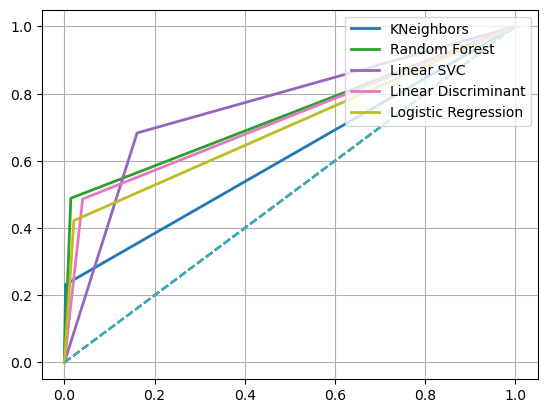

In [167]:
# Plotting a roc_curve for each model to determine performance

def get_prediction_cv(model, X, y):
    return cross_val_predict(model, X_train, y_train, cv=10, verbose=2, n_jobs=-1)

knn_clf = KNeighborsClassifier(n_neighbors=120, n_jobs=-1)
fpr1, tpr1, thresholds = roc_curve(y_train, get_prediction_cv(knn_clf, X_train, y_train))

rnd_clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
fpr2, tpr2, thresholds = roc_curve(y_train, get_prediction_cv(rnd_clf, X_train, y_train))

svm_clf = LinearSVC(verbose=2, class_weight="balanced", C=0.001, loss="hinge")
fpr3, tpr3, thresholds = roc_curve(y_train, get_prediction_cv(svm_clf, X_train, y_train))

lda_clf = LinearDiscriminantAnalysis()
fpr4, tpr4, thresholds = roc_curve(y_train, get_prediction_cv(lda_clf, X_train, y_train))

log_reg = LogisticRegression(solver="liblinear", random_state=42)
fpr5, tpr5, thresholds = roc_curve(y_train, get_prediction_cv(log_reg, X_train, y_train))

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], '--') # dashed diagonal
    
plot_roc_curve(fpr1, tpr1, "KNeighbors")
plot_roc_curve(fpr2, tpr2, "Random Forest")
plot_roc_curve(fpr3, tpr3, "Linear SVC")
plot_roc_curve(fpr4, tpr4, "Linear Discriminant")
plot_roc_curve(fpr5, tpr5, "Logistic Regression")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [103]:
# Selecting features using RFE, testing out total number of features (51) to (42)

result_fe = list()
for i in range(X_train.shape[1], X_train.shape[1] - 10, -1):
    rfe = RFE(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), n_features_to_select=i)
    score = evaluate_model(rfe, X_train, y_train)
    print(f"Number of features: {i}\nMean score: {score.mean()}")
    result_fe.append(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.5s finished


Number of features: 51
Mean score: 0.8825098933933063


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.7s finished


Number of features: 50
Mean score: 0.8826618480898779


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   43.9s finished


Number of features: 49
Mean score: 0.8816337990131443


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Number of features: 48
Mean score: 0.8825639678732798


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Number of features: 47
Mean score: 0.8813701263339242


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Number of features: 46
Mean score: 0.8821598868052213


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished


Number of features: 45
Mean score: 0.8821362295087735


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


Number of features: 44
Mean score: 0.8819151526035801


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


Number of features: 43
Mean score: 0.8815396970645363


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Number of features: 42
Mean score: 0.8813647477774004


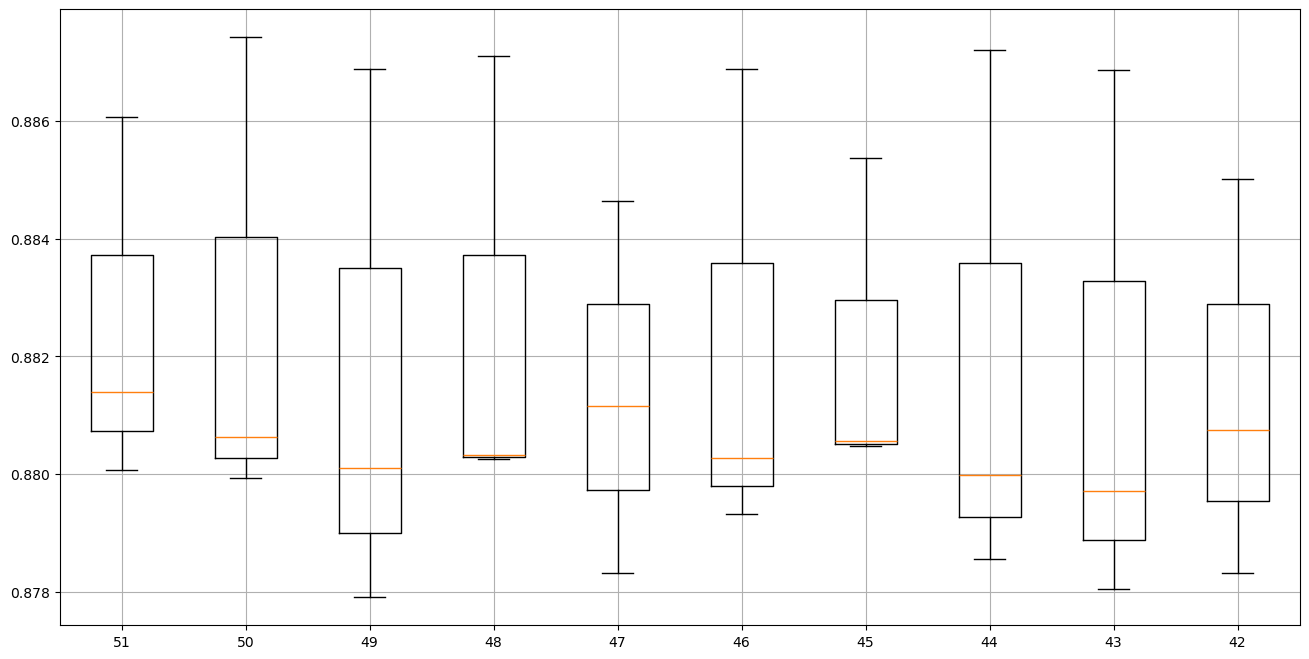

In [104]:
plt.figure(figsize=(16, 8))
plt.boxplot(result_fe, labels=[i for i in range(51, 41, -1)])
plt.grid(True)
# plt.ylim([0.845, 0.86])
plt.show()

In [ ]:
# Observation:
# 51 features has more stability than the rest, judging by the mean (50) is the best but 51 has a higher median.
# 51 features is safer since its performance is not biased by an outlier

# Action:
# Investigation with another feature selection method

In [106]:
# Testing out feature selection with svm model

from sklearn.feature_selection import RFE
result_fe = list()
for i in range(X_train.shape[1], X_train.shape[1] - 15, -1):
    rfe = RFE(LinearSVC(C=0.001, random_state=42), n_features_to_select=i)
    score = evaluate_model(rfe, X_train, y_train)
    print(f"Number of features: {i}\nMean score: {score.mean()}")
    result_fe.append(score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Number of features: 51
Mean score: 0.8194724333771323


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Number of features: 50
Mean score: 0.819482093892996


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


Number of features: 49
Mean score: 0.8194849312795984


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Number of features: 48
Mean score: 0.819463155225787


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Number of features: 47
Mean score: 0.8194358982515436


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Number of features: 46
Mean score: 0.8194108276548585


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Number of features: 45
Mean score: 0.8194276801335851


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Number of features: 44
Mean score: 0.8194502226623769


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Number of features: 43
Mean score: 0.8193321137236552


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Number of features: 42
Mean score: 0.8191774539189991


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Number of features: 41
Mean score: 0.8189954970346723


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Number of features: 40
Mean score: 0.8187845270737015


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Number of features: 39
Mean score: 0.818760099378829


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


Number of features: 38
Mean score: 0.8183248755065722


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Number of features: 37
Mean score: 0.8176856044364572


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


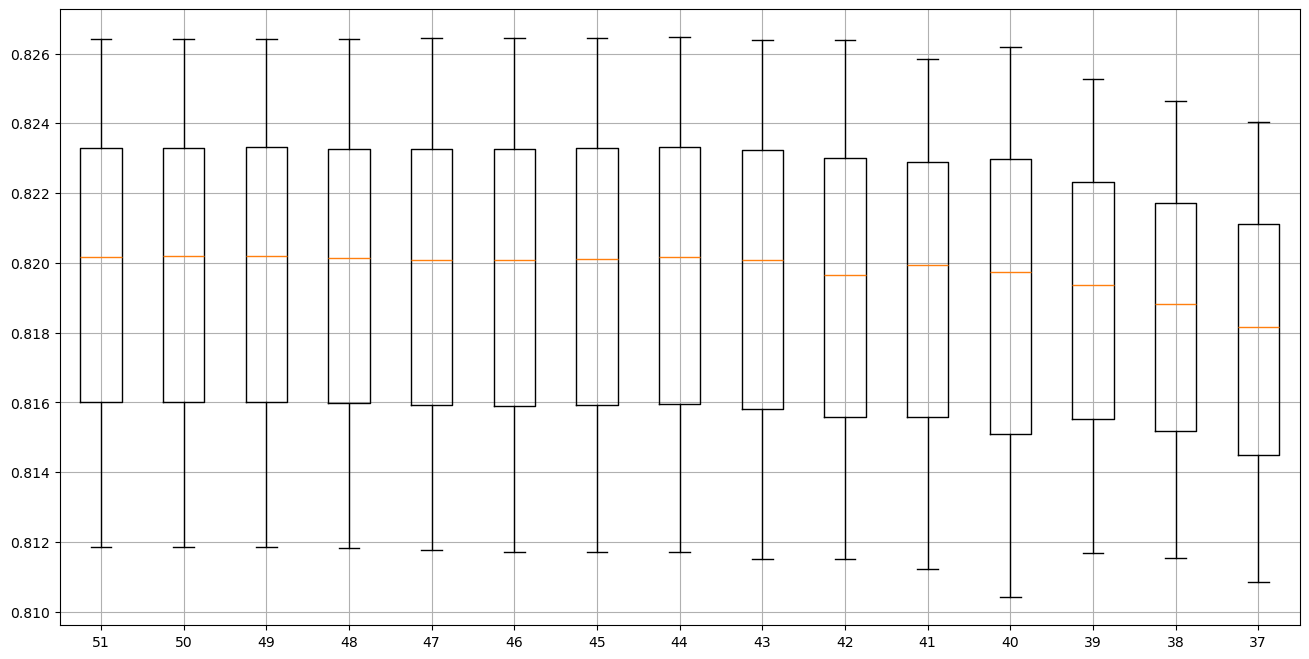

In [107]:
# Plotting the results

plt.figure(figsize=(16, 8))
plt.boxplot(result_fe, labels=[i for i in range(51, 36, -1)])
plt.grid(True)
# plt.ylim([0.845, 0.86])
plt.show()

In [109]:
# Extracting columns sorted by importance by Random Forest's feature importance

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
rnd_features = pd.Series(rnd_clf.feature_importances_, rnd_clf.feature_names_in_).sort_values(ascending=False).index

In [110]:
# Testing out the combination of columns on the dataset and printing out the score

result_rnd = list()
for i in range(41, len(rnd_features) + 1):
    score = evaluate_model(rnd_clf, X_train[rnd_features[:i]], y_train)
    result_rnd.append(score)
    print(f"Number of features: {i}\nMean score {score.mean()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.7s finished


Number of features: 41
Mean score 0.8821541768715111


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished


Number of features: 42
Mean score 0.8822602374334738


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.1s finished


Number of features: 43
Mean score 0.8826316680851094


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.7s finished


Number of features: 44
Mean score 0.8814829455672039


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.2s finished


Number of features: 45
Mean score 0.8822798129970574


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.0s finished


Number of features: 46
Mean score 0.881707531545728


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.5s finished


Number of features: 47
Mean score 0.8830427975591985


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished


Number of features: 48
Mean score 0.8824936668748332


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.6s finished


Number of features: 49
Mean score 0.8813545586754645


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.1s finished


Number of features: 50
Mean score 0.8822643612106055


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.1s finished


Number of features: 51
Mean score 0.8817226386802188


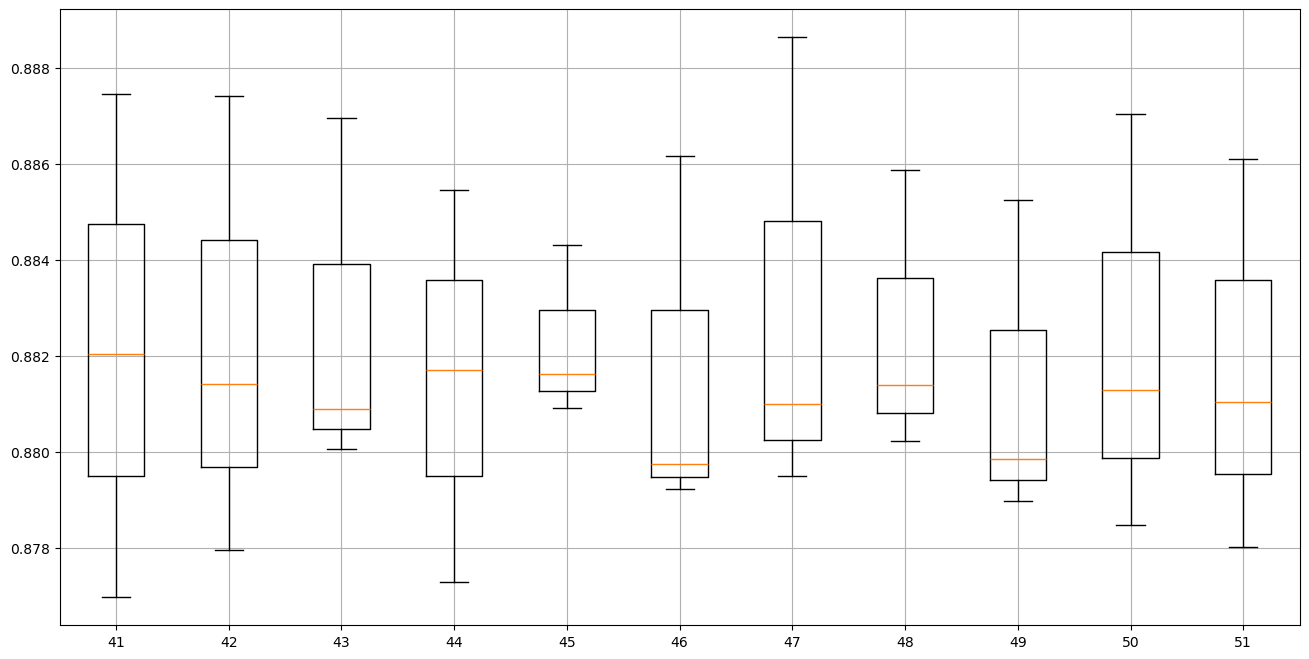

In [111]:
# Plotting the results

plt.figure(figsize=(16, 8))
plt.boxplot(result_rnd, labels=[i for i in range(41, len(rnd_features) + 1)])
plt.grid(True)
# plt.ylim([0.845, 0.86])
plt.show()

In [112]:
# A function for using randomized tuning for tuning parameters

def tune_hyperparameters(model, X, y, param_distribs):
    rnd_search = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter=7, cv=3, scoring='roc_auc',
                               random_state=42, verbose=2)
    rnd_search.fit(X, y)
    return rnd_search

In [113]:
# param_distribs = {'n_estimators': randint(low=150, high=300), 'max_features': randint(low=8, high=30), "max_depth": randint(low=8, high=30)}
# rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# rnd_tuned = tune_hyperparameters(rnd_clf, X_train[rnd_features[:47]], y_train, param_distribs)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ....max_depth=14, max_features=27, n_estimators=242; total time=  23.8s
[CV] END ....max_depth=14, max_features=27, n_estimators=242; total time=  26.0s
[CV] END ....max_depth=14, max_features=27, n_estimators=242; total time=  23.5s
[CV] END ....max_depth=22, max_features=18, n_estimators=221; total time=  20.9s
[CV] END ....max_depth=22, max_features=18, n_estimators=221; total time=  24.3s
[CV] END ....max_depth=22, max_features=18, n_estimators=221; total time=  24.6s
[CV] END ....max_depth=28, max_features=14, n_estimators=271; total time=  24.8s
[CV] END ....max_depth=28, max_features=14, n_estimators=271; total time=  26.9s
[CV] END ....max_depth=28, max_features=14, n_estimators=271; total time=  24.9s
[CV] END ....max_depth=26, max_features=18, n_estimators=237; total time=  25.9s
[CV] END ....max_depth=26, max_features=18, n_estimators=237; total time=  24.0s
[CV] END ....max_depth=26, max_features=18, n_est

In [116]:
# rnd_tuned.best_score_, rnd_tuned.best_estimator_

(0.8875278242363857,
 RandomForestClassifier(max_depth=26, max_features=18, n_estimators=237,
                        n_jobs=-1, random_state=42))

In [171]:
# Best Random Forest model

rnd_best = RandomForestClassifier(max_depth=26, max_features=18, n_estimators=237,
                        n_jobs=-1, random_state=42)

In [118]:
param_distribs = {'min_samples_leaf': randint(low=4, high=24), 'max_features': randint(low=8, high=30), "max_depth": randint(low=8, high=30),
                 "max_leaf_nodes": randint(low=3, high=24)}

dcs_clf = DecisionTreeClassifier(random_state=42)
dcs_tuned = tune_hyperparameters(dcs_clf, X_train, y_train, param_distribs)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END max_depth=14, max_features=27, max_leaf_nodes=17, min_samples_leaf=14; total time=   0.2s
[CV] END max_depth=14, max_features=27, max_leaf_nodes=17, min_samples_leaf=14; total time=   0.2s
[CV] END max_depth=14, max_features=27, max_leaf_nodes=17, min_samples_leaf=14; total time=   0.2s
[CV] END max_depth=15, max_features=28, max_leaf_nodes=9, min_samples_leaf=22; total time=   0.1s
[CV] END max_depth=15, max_features=28, max_leaf_nodes=9, min_samples_leaf=22; total time=   0.2s
[CV] END max_depth=15, max_features=28, max_leaf_nodes=9, min_samples_leaf=22; total time=   0.2s
[CV] END max_depth=18, max_features=18, max_leaf_nodes=23, min_samples_leaf=7; total time=   0.1s
[CV] END max_depth=18, max_features=18, max_leaf_nodes=23, min_samples_leaf=7; total time=   0.1s
[CV] END max_depth=18, max_features=18, max_leaf_nodes=23, min_samples_leaf=7; total time=   0.1s
[CV] END max_depth=15, max_features=10, max_leaf_nodes=

In [120]:
# dcs_tuned.best_score_, dcs_tuned.best_estimator_

(0.7955318150607433,
 DecisionTreeClassifier(max_depth=17, max_features=23, max_leaf_nodes=17,
                        min_samples_leaf=18, random_state=42))

In [172]:
# Best Decision Tree model

dcs_best = DecisionTreeClassifier(max_depth=17, max_features=23, max_leaf_nodes=17,
                        min_samples_leaf=18, random_state=42)

In [122]:
# param_distribs = {'C': randint(low=1, high=500), 'max_iter': randint(low=500, high=5000)}

# svm_clf = LinearSVC()
# svm_tuned = tune_hyperparameters(svm_clf, X_train, y_train, param_distribs)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ...............................C=103, max_iter=1360; total time=  15.8s
[CV] END ...............................C=103, max_iter=1360; total time=  16.8s
[CV] END ...............................C=103, max_iter=1360; total time=  16.6s
[CV] END ...............................C=271, max_iter=4272; total time= 1.0min
[CV] END ...............................C=271, max_iter=4272; total time=  55.9s
[CV] END ...............................C=271, max_iter=4272; total time=  54.4s
[CV] END .................................C=21, max_iter=966; total time=  13.3s
[CV] END .................................C=21, max_iter=966; total time=  10.5s
[CV] END .................................C=21, max_iter=966; total time=  11.1s
[CV] END ...............................C=215, max_iter=4926; total time=  58.2s
[CV] END ...............................C=215, max_iter=4926; total time= 1.0min
[CV] END ...............................C=215, ma

In [173]:
# Best SVM model

svm_best = LinearSVC(C=100, max_iter=3419)

In [179]:
# A function for detecting data drift
# if the distribution of a feature in two datasets is somehow different, the mechanism responds to the effect
# the mechanism uses a statistical test to set up a p_value that is compared to a threshold
# if the threshold has been passed, it shows that their is data drift

def detect_data_drift(X_new, X_train, threshold=0.05):
    for feature in X_new.columns:
        stat, pvalue = ks_2samp(X_new[feature], X_train[feature])
        if pvalue < threshold:
            print(f"Data drift detected in feature: {feature}")
            return True

    return False

detect_data_drift(X_valid, X_train)

Data drift detected in feature: salary


True

In [176]:
# Trying out some ensemble techniques

ada_clf = AdaBoostClassifier(estimator=rnd_best, n_estimators=100, random_state=42)

In [177]:
# Evaluating best models on the validation dataset

best_models = (
    ("RandomForestClassifier", rnd_best),
    ("DecisionTree", dcs_best),
    ("SVM", svm_best),
    ("Adaboost", ada_clf),
)

def evaluate_validation(X_test, y_test):
    for model_name, model in best_models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\n{model_name} - Validation Results:")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))

In [178]:
evaluate_validation(X_valid, y_valid)


RandomForestClassifier - Validation Results:
ROC-AUC: 0.7797
Accuracy: 0.9239
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     17027
           1       0.87      0.57      0.69      2973

    accuracy                           0.92     20000
   macro avg       0.90      0.78      0.82     20000
weighted avg       0.92      0.92      0.92     20000


DecisionTree - Validation Results:
ROC-AUC: 0.6706
Accuracy: 0.8861
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     17027
           1       0.74      0.36      0.49      2973

    accuracy                           0.89     20000
   macro avg       0.82      0.67      0.71     20000
weighted avg       0.87      0.89      0.87     20000


SVM - Validation Results:
ROC-AUC: 0.6575
Accuracy: 0.8872
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     17027
           1       0.79      

In [180]:
shap.initjs()

In [184]:
explainer = shap.Explainer(LogisticRegression().fit(X_train, y_train).predict, X_valid)
shap_values = explainer(X_valid)

PermutationExplainer explainer: 20001it [09:01, 36.18it/s]                           


In [185]:
def features_explainer(index, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[index])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[index])
    else:
        return 'Select a valid type of plot: "condensed" or "waterfall"'

In [186]:
features_explainer(0)

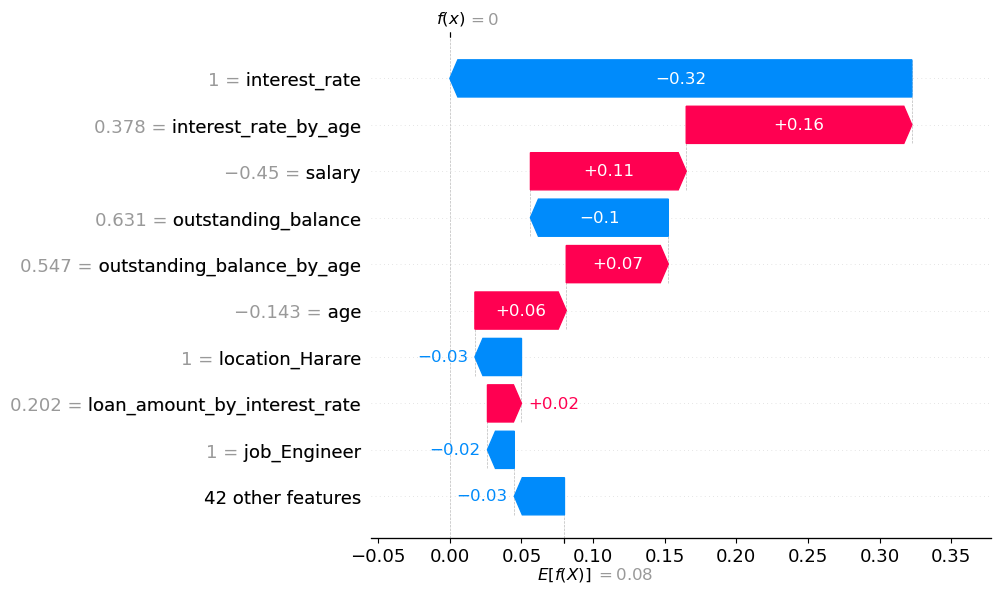

In [187]:
features_explainer(0, "waterfall")

In [188]:
# From the diagram, predictions are based off of interest rate, interest_rate_by_age, salary and outstanding balance

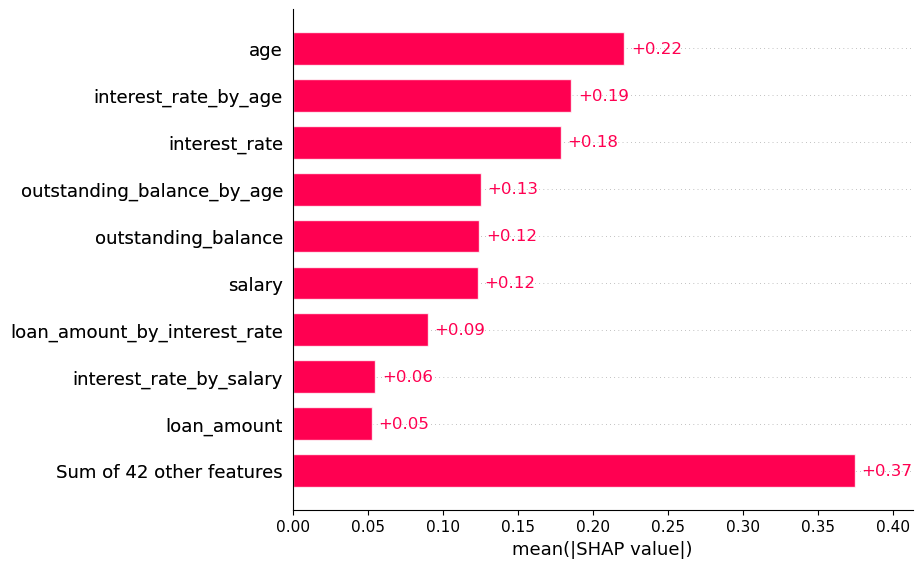

In [189]:
# Let's plot the featureof importance for the logistic regression model
shap.plots.bar(shap_values)

In [190]:
# The 3 most important features determining predictions are age, interest_rate_by_age, interest_rate

In [191]:
# Dumping models and pipelines as pickle file

filename = os.path.join("", 'model.pkl')
pickle.dump(rnd_best, open(filename, 'wb'))

filename = os.path.join("", 'cleaner.pkl')
pickle.dump(StarterCleaner(), open(filename, 'wb'))

filename = os.path.join("", 'feature.pkl')
pickle.dump(CreateFeatures(), open(filename, 'wb'))